# ResNet Architecture Comparison

This notebook compares different ResNet architectures on the footprint classification task:
- **ResNet-18**: 18 layers, ~11M parameters
- **ResNet-34**: 34 layers, ~21M parameters
- **ResNet-50**: 50 layers, ~25M parameters (bottleneck blocks)
- **ResNet-101**: 101 layers, ~44M parameters
- **ResNet-152**: 152 layers, ~60M parameters

**Goal**: Find the optimal ResNet depth for footprint sex classification.

In [ ]:
# =============================================================================
# Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 3080


In [ ]:
# =============================================================================
# Configuration
# =============================================================================

# Data settings
DATA_DIR = Path('./data')
TRAIN_DIR = DATA_DIR / 'train'
IS_GRAYSCALE = True
INPUT_CHANNELS = 1 if IS_GRAYSCALE else 3
IMG_SIZE = 224

# =============================================================================
# OPTIMAL HYPERPARAMETERS (from main notebook experiments)
# =============================================================================
# Exp 1: AdamW optimizer (82.86%)
# Exp 2: StepLR scheduler (83.49%)
# Exp 3: Dropout 0.5 (85.08%)
# Exp 4: Batch size 32 (83.17%)
# Exp 7: HorizontalFlip augmentation (86.35%)
# Exp 8: Weight decay 0.0001 (83.81%)
# Exp 9: Early stopping patience=5 (85.40%)
# =============================================================================

BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
DROPOUT = 0.5
EARLY_STOPPING_PATIENCE = 5

# Models to compare (ResNet-18 to ResNet-50)
RESNET_MODELS = {
    'ResNet-18': (models.resnet18, models.ResNet18_Weights.IMAGENET1K_V1),
    'ResNet-34': (models.resnet34, models.ResNet34_Weights.IMAGENET1K_V1),
    'ResNet-50': (models.resnet50, models.ResNet50_Weights.IMAGENET1K_V1),
}

print('Configuration loaded - Using optimal hyperparameters')
print(f'Models to compare: {list(RESNET_MODELS.keys())}')
print(f'Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, Dropout: {DROPOUT}')
print(f'LR: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}, Early Stopping: {EARLY_STOPPING_PATIENCE}')

Configuration loaded - Using optimal hyperparameters
Models to compare: ['ResNet-18', 'ResNet-34', 'ResNet-50']
Epochs: 20, Batch Size: 32, Dropout: 0.5
LR: 0.001, Weight Decay: 0.0001, Early Stopping: 5


In [ ]:
# =============================================================================
# Data Loading
# =============================================================================

# Load training data (folders are named 0 and 1)
female_paths = list((TRAIN_DIR / '0').glob('*'))  # 0 = Female
male_paths = list((TRAIN_DIR / '1').glob('*'))    # 1 = Male

all_paths = female_paths + male_paths
all_labels = [0] * len(female_paths) + [1] * len(male_paths)

print(f'Total samples: {len(all_paths)}')
print(f'Female (0): {len(female_paths)}, Male (1): {len(male_paths)}')

# Train/val split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f'Train: {len(train_paths)}, Val: {len(val_paths)}')

# Dataset class
class FootprintDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('L' if IS_GRAYSCALE else 'RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create datasets and loaders
train_dataset = FootprintDataset(train_paths, train_labels, train_transform)
val_dataset = FootprintDataset(val_paths, val_labels, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print('Data loaders ready')

Total samples: 1573
Female (0): 845, Male (1): 728
Train: 1258, Val: 315
Data loaders ready


In [ ]:
# =============================================================================
# Model Creation Function
# =============================================================================

def create_resnet_model(model_name):
    """Create a ResNet model configured for grayscale footprint classification"""
    model_fn, weights = RESNET_MODELS[model_name]
    model = model_fn(weights=weights)
    
    # Modify first conv for grayscale input
    if INPUT_CHANNELS == 1:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Replace FC layer with dropout + linear for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT),
        nn.Linear(num_features, 2)
    )
    
    return model.to(device)

def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test model creation
print('Testing model creation...')
for name in RESNET_MODELS.keys():
    model = create_resnet_model(name)
    params = count_parameters(model)
    print(f'{name}: {params:,} parameters')
    del model
    torch.cuda.empty_cache()

Testing model creation...
ResNet-18: 11,171,266 parameters
ResNet-34: 21,279,426 parameters
ResNet-50: 23,505,858 parameters


In [ ]:
# =============================================================================
# Training Function
# =============================================================================

def train_model(model, model_name, num_epochs=NUM_EPOCHS):
    """Train a model and return results"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    train_history = []
    val_history = []
    best_acc = 0.0
    epochs_without_improvement = 0
    start_time = time.time()
    actual_epochs = 0
    
    for epoch in range(num_epochs):
        actual_epochs += 1
        
        # Training phase
        model.train()
        train_correct, train_total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = train_correct / train_total
        train_history.append(train_acc)
        
        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_history.append(val_acc)
        
        # Early stopping check
        if val_acc > best_acc:
            best_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'  Epoch {epoch+1}/{num_epochs} - Train: {train_acc:.4f}, Val: {val_acc:.4f}')
        
        # Early stopping
        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print(f'  Early stopping at epoch {epoch+1}')
            break
    
    train_time = time.time() - start_time
    
    return {
        'model_name': model_name,
        'best_val_acc': best_acc,
        'final_val_acc': val_history[-1],
        'final_train_acc': train_history[-1],
        'train_time': train_time,
        'train_history': train_history,
        'val_history': val_history,
        'parameters': count_parameters(model),
        'epochs_trained': actual_epochs
    }

print('Training function ready (with early stopping)')

Training function ready (with early stopping)


In [ ]:
# =============================================================================
# Run ResNet Comparison
# =============================================================================

results = []

print('=' * 70)
print('RESNET ARCHITECTURE COMPARISON')
print('=' * 70)

for model_name in RESNET_MODELS.keys():
    print(f'\nTraining {model_name}...')
    print('-' * 40)
    
    # Create fresh model
    model = create_resnet_model(model_name)
    
    # Train and get results
    result = train_model(model, model_name)
    results.append(result)
    
    print(f'\n✓ {model_name} Complete:')
    print(f'  Best Val Accuracy: {result["best_val_acc"]:.4f}')
    print(f'  Training Time: {result["train_time"]:.1f}s')
    print(f'  Parameters: {result["parameters"]:,}')
    
    # Clean up
    del model
    torch.cuda.empty_cache()

print('\n' + '=' * 70)
print('ALL MODELS TRAINED')
print('=' * 70)

RESNET ARCHITECTURE COMPARISON

Training ResNet-18...
----------------------------------------
  Epoch 5/20 - Train: 0.8426, Val: 0.6540
  Epoch 10/20 - Train: 0.9261, Val: 0.8825
  Epoch 15/20 - Train: 0.9587, Val: 0.8794
  Epoch 20/20 - Train: 0.9650, Val: 0.8825

✓ ResNet-18 Complete:
  Best Val Accuracy: 0.8889
  Training Time: 358.1s
  Parameters: 11,171,266

Training ResNet-34...
----------------------------------------
  Epoch 5/20 - Train: 0.8331, Val: 0.7365
  Epoch 10/20 - Train: 0.9213, Val: 0.8762
  Early stopping at epoch 13

✓ ResNet-34 Complete:
  Best Val Accuracy: 0.8952
  Training Time: 255.9s
  Parameters: 21,279,426

Training ResNet-50...
----------------------------------------
  Epoch 5/20 - Train: 0.8211, Val: 0.6190
  Epoch 10/20 - Train: 0.8998, Val: 0.8222
  Epoch 15/20 - Train: 0.9459, Val: 0.8571
  Early stopping at epoch 17

✓ ResNet-50 Complete:
  Best Val Accuracy: 0.8603
  Training Time: 340.3s
  Parameters: 23,505,858

ALL MODELS TRAINED


In [ ]:
# =============================================================================
# Results Summary
# =============================================================================

# Create results dataframe
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Best Val Acc': r['best_val_acc'],
    'Final Val Acc': r['final_val_acc'],
    'Train Acc': r['final_train_acc'],
    'Overfit Gap': r['final_train_acc'] - r['final_val_acc'],
    'Epochs': r['epochs_trained'],
    'Train Time (s)': r['train_time'],
    'Parameters (M)': r['parameters'] / 1e6
} for r in results])

# Sort by best validation accuracy
results_df = results_df.sort_values('Best Val Acc', ascending=False).reset_index(drop=True)

print('=' * 70)
print('RESNET COMPARISON RESULTS')
print('=' * 70)
print()
print(results_df.to_string(index=False))

# Find best model
best_model = results_df.iloc[0]['Model']
best_acc = results_df.iloc[0]['Best Val Acc']
print(f'\n★ BEST MODEL: {best_model} with {best_acc:.4f} validation accuracy')

RESNET COMPARISON RESULTS

    Model  Best Val Acc  Final Val Acc  Train Acc  Overfit Gap  Epochs  Train Time (s)  Parameters (M)
ResNet-34      0.895238       0.812698   0.930843     0.118144      13      255.919956       21.279426
ResNet-18      0.888889       0.882540   0.965024     0.082484      20      358.063899       11.171266
ResNet-50      0.860317       0.860317   0.945946     0.085628      17      340.315252       23.505858

★ BEST MODEL: ResNet-34 with 0.8952 validation accuracy


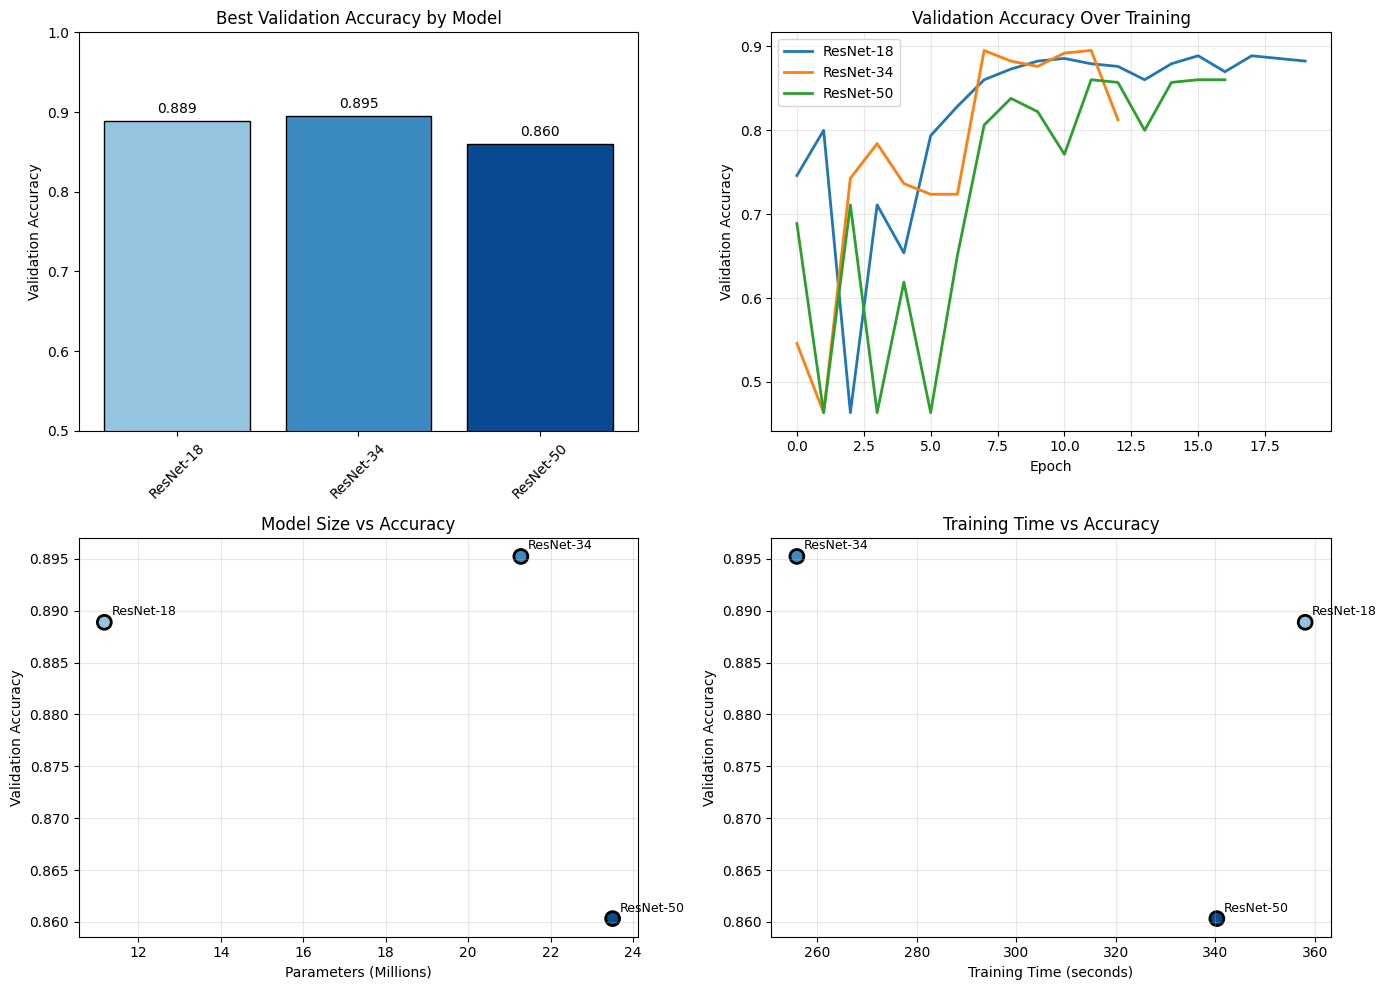


Figure saved as resnet_comparison.png


In [ ]:
# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Validation Accuracy Comparison
ax1 = axes[0, 0]
models_list = [r['model_name'] for r in results]
val_accs = [r['best_val_acc'] for r in results]
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(models_list)))
bars = ax1.bar(models_list, val_accs, color=colors, edgecolor='black')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Best Validation Accuracy by Model')
ax1.set_ylim(0.5, 1.0)
ax1.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', fontsize=10)

# Plot 2: Training Curves
ax2 = axes[0, 1]
for r in results:
    ax2.plot(r['val_history'], label=r['model_name'], linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy Over Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Parameters vs Accuracy
ax3 = axes[1, 0]
params = [r['parameters']/1e6 for r in results]
accs = [r['best_val_acc'] for r in results]
ax3.scatter(params, accs, s=100, c=colors, edgecolors='black', linewidths=2)
for i, r in enumerate(results):
    ax3.annotate(r['model_name'], (params[i], accs[i]), 
                 textcoords='offset points', xytext=(5,5), fontsize=9)
ax3.set_xlabel('Parameters (Millions)')
ax3.set_ylabel('Validation Accuracy')
ax3.set_title('Model Size vs Accuracy')
ax3.grid(True, alpha=0.3)

# Plot 4: Training Time vs Accuracy
ax4 = axes[1, 1]
times = [r['train_time'] for r in results]
ax4.scatter(times, accs, s=100, c=colors, edgecolors='black', linewidths=2)
for i, r in enumerate(results):
    ax4.annotate(r['model_name'], (times[i], accs[i]), 
                 textcoords='offset points', xytext=(5,5), fontsize=9)
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Validation Accuracy')
ax4.set_title('Training Time vs Accuracy')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nFigure saved as resnet_comparison.png')

## Conclusions

Based on the comparison:

1. **Best Accuracy**: Check which ResNet depth achieved highest validation accuracy
2. **Efficiency**: Consider the accuracy vs parameters/training time trade-off
3. **Overfitting**: Larger models may show bigger train-val gap

### Recommendations:
- If accuracy is similar, prefer smaller model (faster inference)
- If larger model is significantly better, the extra compute is justified
- Consider the overfitting gap when selecting final model

## ResNet-34 Hyperparameter Tuning

Now that we've identified ResNet-34 as the best architecture, let's tune its hyperparameters to maximize performance.

**Tuning targets:**
- Learning Rate
- Dropout Rate
- Weight Decay
- Scheduler Type

In [ ]:
# =============================================================================
# ResNet-34 Hyperparameter Tuning
# =============================================================================

def create_resnet34_tuned(dropout_rate=0.5):
    """Create ResNet-34 with configurable dropout"""
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    
    if INPUT_CHANNELS == 1:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, 2)
    )
    
    return model.to(device)

def train_with_config(config, num_epochs=25, patience=7):
    """Train ResNet-34 with specific configuration"""
    model = create_resnet34_tuned(dropout_rate=config['dropout'])
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    
    # Scheduler selection
    if config['scheduler'] == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    elif config['scheduler'] == 'CosineAnnealing':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif config['scheduler'] == 'ReduceOnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    
    best_acc = 0.0
    epochs_without_improvement = 0
    train_history, val_history = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_correct, train_total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = train_correct / train_total
        train_history.append(train_acc)
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_history.append(val_acc)
        
        # Update scheduler
        if config['scheduler'] == 'ReduceOnPlateau':
            scheduler.step(val_acc)
        else:
            scheduler.step()
        
        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            break
    
    final_gap = train_history[-1] - val_history[-1]
    
    del model
    torch.cuda.empty_cache()
    
    return {
        'config': config,
        'best_val_acc': best_acc,
        'final_train_acc': train_history[-1],
        'final_val_acc': val_history[-1],
        'overfit_gap': final_gap,
        'epochs': len(train_history)
    }

print("Tuning functions ready")

Tuning functions ready


In [ ]:
# =============================================================================
# Run Hyperparameter Tuning
# =============================================================================

# Define configurations to test
configs = [
    # Baseline (current best)
    {'name': 'Baseline', 'lr': 0.001, 'dropout': 0.5, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    
    # Learning Rate variations
    {'name': 'Lower LR', 'lr': 0.0005, 'dropout': 0.5, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    {'name': 'Higher LR', 'lr': 0.002, 'dropout': 0.5, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    
    # Dropout variations
    {'name': 'Dropout 0.6', 'lr': 0.001, 'dropout': 0.6, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    {'name': 'Dropout 0.7', 'lr': 0.001, 'dropout': 0.7, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    
    # Weight Decay variations
    {'name': 'Higher WD', 'lr': 0.001, 'dropout': 0.5, 'weight_decay': 5e-4, 'scheduler': 'StepLR'},
    
    # Scheduler variations
    {'name': 'Cosine Annealing', 'lr': 0.001, 'dropout': 0.5, 'weight_decay': 1e-4, 'scheduler': 'CosineAnnealing'},
    {'name': 'ReduceOnPlateau', 'lr': 0.001, 'dropout': 0.5, 'weight_decay': 1e-4, 'scheduler': 'ReduceOnPlateau'},
    
    # Combined optimizations
    {'name': 'Lower LR + Dropout 0.6', 'lr': 0.0005, 'dropout': 0.6, 'weight_decay': 1e-4, 'scheduler': 'StepLR'},
    {'name': 'Cosine + Dropout 0.6', 'lr': 0.001, 'dropout': 0.6, 'weight_decay': 1e-4, 'scheduler': 'CosineAnnealing'},
]

print('=' * 70)
print('RESNET-34 HYPERPARAMETER TUNING')
print('=' * 70)
print(f'Testing {len(configs)} configurations...\n')

tuning_results = []

for i, config in enumerate(configs):
    print(f"[{i+1}/{len(configs)}] Testing: {config['name']}")
    print(f"    LR={config['lr']}, Dropout={config['dropout']}, WD={config['weight_decay']}, Scheduler={config['scheduler']}")
    
    result = train_with_config(config, num_epochs=25, patience=7)
    result['name'] = config['name']
    tuning_results.append(result)
    
    print(f"    → Best Val Acc: {result['best_val_acc']:.4f}, Overfit Gap: {result['overfit_gap']:.4f}, Epochs: {result['epochs']}\n")

print('=' * 70)
print('TUNING COMPLETE')
print('=' * 70)

RESNET-34 HYPERPARAMETER TUNING
Testing 10 configurations...

[1/10] Testing: Baseline
    LR=0.001, Dropout=0.5, WD=0.0001, Scheduler=StepLR
    → Best Val Acc: 0.9048, Overfit Gap: 0.0642, Epochs: 17

[2/10] Testing: Lower LR
    LR=0.0005, Dropout=0.5, WD=0.0001, Scheduler=StepLR
    → Best Val Acc: 0.9079, Overfit Gap: 0.0952, Epochs: 16

[3/10] Testing: Higher LR
    LR=0.002, Dropout=0.5, WD=0.0001, Scheduler=StepLR
    → Best Val Acc: 0.8952, Overfit Gap: 0.0276, Epochs: 17

[4/10] Testing: Dropout 0.6
    LR=0.001, Dropout=0.6, WD=0.0001, Scheduler=StepLR
    → Best Val Acc: 0.9016, Overfit Gap: 0.0801, Epochs: 23

[5/10] Testing: Dropout 0.7
    LR=0.001, Dropout=0.7, WD=0.0001, Scheduler=StepLR
    → Best Val Acc: 0.8857, Overfit Gap: 0.0554, Epochs: 21

[6/10] Testing: Higher WD
    LR=0.001, Dropout=0.5, WD=0.0005, Scheduler=StepLR
    → Best Val Acc: 0.8698, Overfit Gap: 0.0991, Epochs: 17

[7/10] Testing: Cosine Annealing
    LR=0.001, Dropout=0.5, WD=0.0001, Scheduler=Co

In [ ]:
# =============================================================================
# Tuning Results Summary
# =============================================================================

# Create results dataframe
tuning_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Best Val Acc': r['best_val_acc'],
    'Final Val Acc': r['final_val_acc'],
    'Train Acc': r['final_train_acc'],
    'Overfit Gap': r['overfit_gap'],
    'Epochs': r['epochs'],
    'LR': r['config']['lr'],
    'Dropout': r['config']['dropout'],
    'Weight Decay': r['config']['weight_decay'],
    'Scheduler': r['config']['scheduler']
} for r in tuning_results])

# Sort by best validation accuracy
tuning_df = tuning_df.sort_values('Best Val Acc', ascending=False).reset_index(drop=True)

print('=' * 70)
print('RESNET-34 HYPERPARAMETER TUNING RESULTS')
print('=' * 70)
print()
print(tuning_df[['Configuration', 'Best Val Acc', 'Overfit Gap', 'Epochs']].to_string(index=False))

# Best configuration
best_config = tuning_df.iloc[0]
print(f"\n{'=' * 70}")
print(f"★ BEST CONFIGURATION: {best_config['Configuration']}")
print(f"{'=' * 70}")
print(f"  Validation Accuracy: {best_config['Best Val Acc']:.4f}")
print(f"  Overfit Gap: {best_config['Overfit Gap']:.4f}")
print(f"  Learning Rate: {best_config['LR']}")
print(f"  Dropout: {best_config['Dropout']}")
print(f"  Weight Decay: {best_config['Weight Decay']}")
print(f"  Scheduler: {best_config['Scheduler']}")

RESNET-34 HYPERPARAMETER TUNING RESULTS

         Configuration  Best Val Acc  Overfit Gap  Epochs
              Lower LR      0.907937     0.095203      16
              Baseline      0.904762     0.064216      17
           Dropout 0.6      0.901587     0.080104      23
             Higher LR      0.895238     0.027630      17
Lower LR + Dropout 0.6      0.888889     0.098357      16
           Dropout 0.7      0.885714     0.055447      21
      Cosine Annealing      0.882540     0.073695      15
             Higher WD      0.869841     0.099132      17
  Cosine + Dropout 0.6      0.869841     0.107901      20
       ReduceOnPlateau      0.834921     0.090358      15

★ BEST CONFIGURATION: Lower LR
  Validation Accuracy: 0.9079
  Overfit Gap: 0.0952
  Learning Rate: 0.0005
  Dropout: 0.5
  Weight Decay: 0.0001
  Scheduler: StepLR


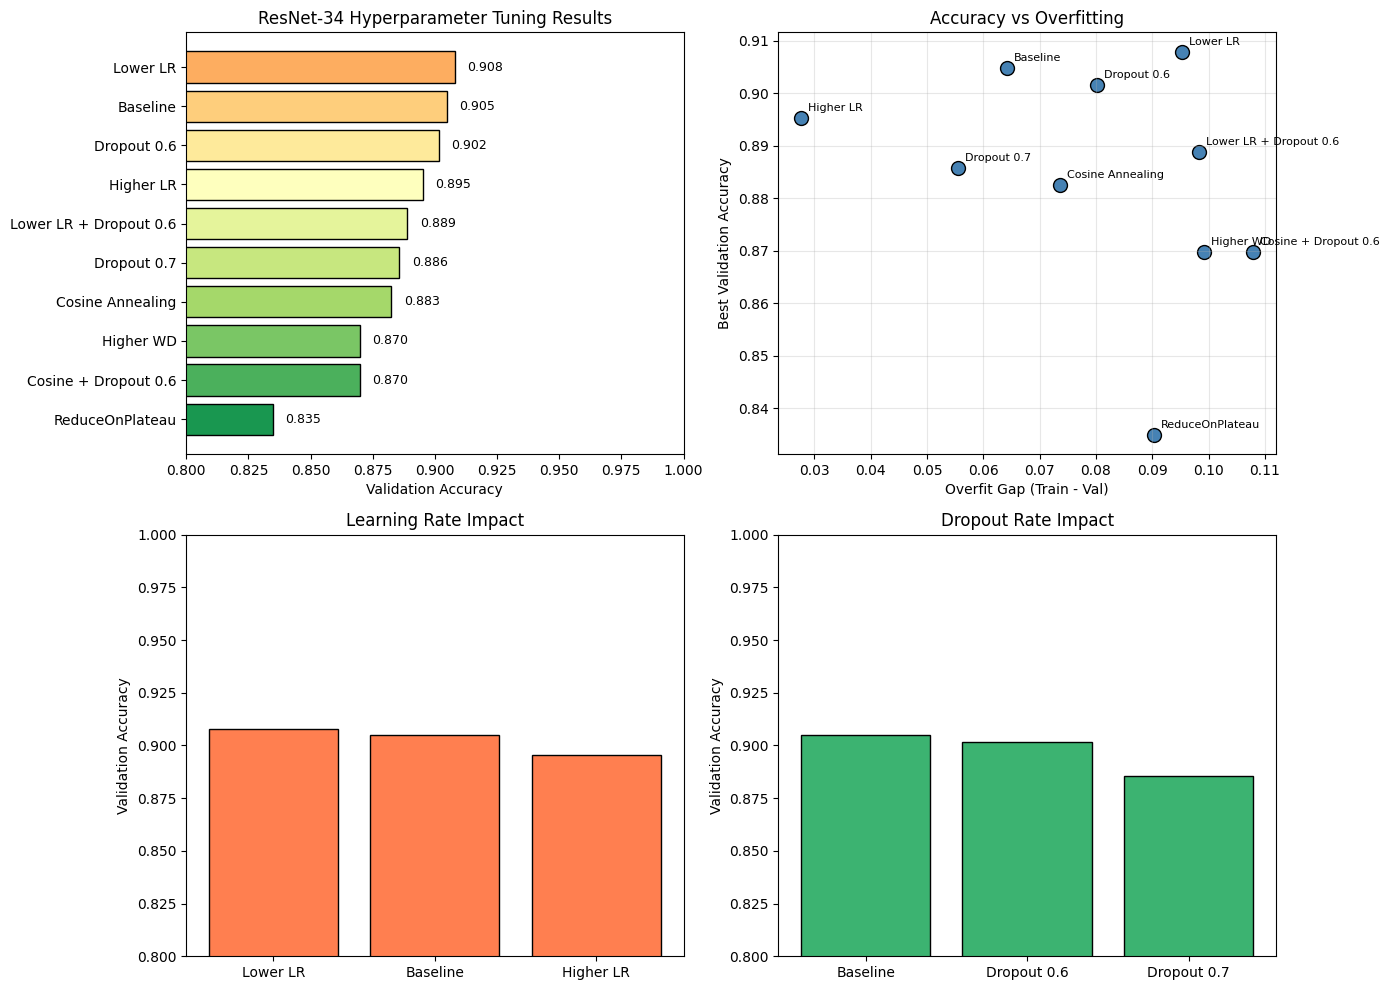


Figure saved as resnet34_tuning.png


In [ ]:
# =============================================================================
# Tuning Visualization
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All configurations comparison
ax1 = axes[0, 0]
configs_names = tuning_df['Configuration'].tolist()
val_accs = tuning_df['Best Val Acc'].tolist()
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(configs_names)))
bars = ax1.barh(configs_names[::-1], val_accs[::-1], color=colors[::-1], edgecolor='black')
ax1.set_xlabel('Validation Accuracy')
ax1.set_title('ResNet-34 Hyperparameter Tuning Results')
ax1.set_xlim(0.8, 1.0)
for bar, acc in zip(bars, val_accs[::-1]):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{acc:.3f}', va='center', fontsize=9)

# Plot 2: Accuracy vs Overfit Gap
ax2 = axes[0, 1]
ax2.scatter(tuning_df['Overfit Gap'], tuning_df['Best Val Acc'], s=100, c='steelblue', edgecolors='black')
for i, row in tuning_df.iterrows():
    ax2.annotate(row['Configuration'], (row['Overfit Gap'], row['Best Val Acc']),
                 textcoords='offset points', xytext=(5, 5), fontsize=8)
ax2.set_xlabel('Overfit Gap (Train - Val)')
ax2.set_ylabel('Best Validation Accuracy')
ax2.set_title('Accuracy vs Overfitting')
ax2.grid(True, alpha=0.3)

# Plot 3: Learning Rate impact
ax3 = axes[1, 0]
lr_results = tuning_df[tuning_df['Configuration'].isin(['Lower LR', 'Baseline', 'Higher LR'])]
if len(lr_results) > 0:
    ax3.bar(lr_results['Configuration'], lr_results['Best Val Acc'], color='coral', edgecolor='black')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_title('Learning Rate Impact')
    ax3.set_ylim(0.8, 1.0)

# Plot 4: Dropout impact
ax4 = axes[1, 1]
dropout_results = tuning_df[tuning_df['Configuration'].isin(['Baseline', 'Dropout 0.6', 'Dropout 0.7'])]
if len(dropout_results) > 0:
    ax4.bar(dropout_results['Configuration'], dropout_results['Best Val Acc'], color='mediumseagreen', edgecolor='black')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Dropout Rate Impact')
    ax4.set_ylim(0.8, 1.0)

plt.tight_layout()
plt.savefig('resnet34_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nFigure saved as resnet34_tuning.png')